In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import time
import xgboost as xgb

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

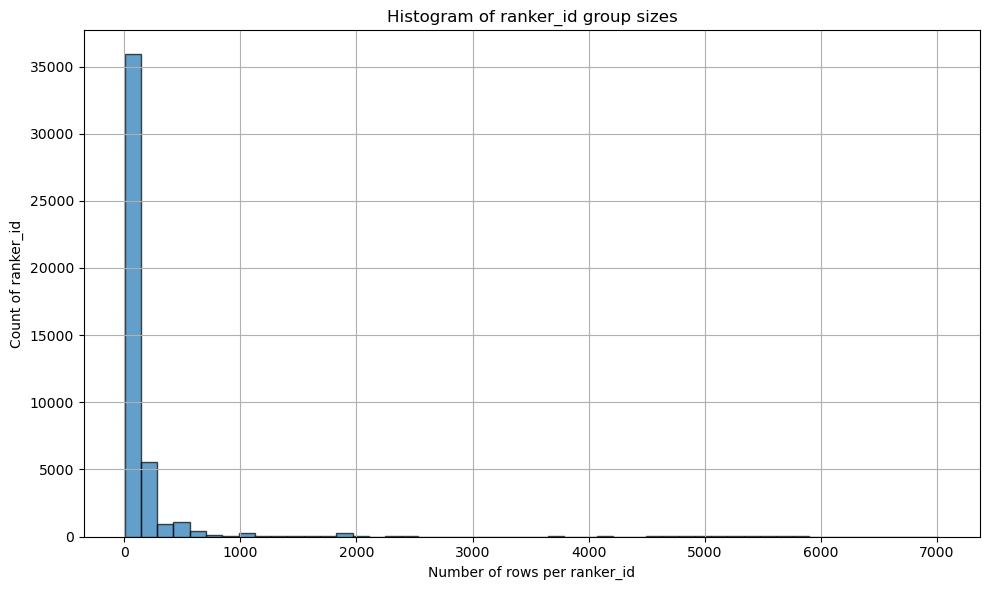

In [5]:
import polars as pl
import matplotlib.pyplot as plt

# Load data
train = pl.read_parquet('data/test_filled.parquet')

# 計算每個 ranker_id 出現次數
ranker_counts = (
    train
    .group_by("ranker_id")
    .agg(pl.len().alias("n_rows"))
    .sort("n_rows")
)

# 轉成 pandas
ranker_counts_pd = ranker_counts.to_pandas()

# 畫 histogram
plt.figure(figsize=(10,6))
plt.hist(ranker_counts_pd["n_rows"], bins=50, edgecolor="k", alpha=0.7)
plt.xlabel("Number of rows per ranker_id")
plt.ylabel("Count of ranker_id")
plt.title("Histogram of ranker_id group sizes")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
ranker_counts_filtered = ranker_counts.filter(pl.col("n_rows") >= 3)
summary_filtered = ranker_counts_filtered.select([
    pl.col("n_rows").min().alias("min"),
    pl.col("n_rows").max().alias("max"),
    pl.col("n_rows").mean().alias("mean"),
    pl.col("n_rows").median().alias("median"),
    pl.col("n_rows").quantile(0.25, "nearest").alias("25%"),
    pl.col("n_rows").quantile(0.5, "nearest").alias("50%"),
    pl.col("n_rows").quantile(0.75, "nearest").alias("75%"),
    pl.col("n_rows").quantile(0.85, "nearest").alias("85%"),
    pl.col("n_rows").quantile(0.95, "nearest").alias("95%"),
    pl.col("n_rows").std().alias("std"),
])

summary_filtered


min,max,mean,median,25%,50%,75%,85%,95%,std
u32,u32,f64,f64,f64,f64,f64,f64,f64,f64
3,7022,159.889564,39.0,16.0,39.0,121.0,212.0,517.0,535.102201


In [1]:
import numpy as np
import polars as pl

# 讀取
train_filled = pl.read_parquet("data/train_with_companyID_features.parquet")

# 排除欄
needed_cols = [
     'ranker_id', 'selected'
]
remove = ['profileId', 'requestDate',
    'legs0_departureAt', 'legs0_arrivalAt', 'legs1_departureAt', 'legs1_arrivalAt',
    'miniRules0_percentage', 'miniRules1_percentage', 
    "n_rows", "__index_level_0__","Id", "companyID"]

exclude_cols = needed_cols + remove

feature_cols = [c for c in train_filled.columns if c not in exclude_cols]

# 轉 float32
float64_cols = [c for c in feature_cols if train_filled[c].dtype == pl.Float64]
train_filled = train_filled.with_columns(
    [pl.col(c).cast(pl.Float32) for c in float64_cols]
)

all_features = feature_cols+needed_cols
train_filled = train_filled.select(all_features)

In [2]:
# 找字串欄
str_cols = [c for c in train_filled.columns if train_filled[c].dtype in (pl.Utf8, pl.String)]
# 找數值欄
numeric_cols = [c for c in train_filled.columns if train_filled[c].dtype.is_numeric()]
# 找布林欄
bool_cols = [c for c in train_filled.columns if train_filled[c].dtype == pl.Boolean]

print(f"✅ 共找到 {len(str_cols)} 個字串欄位")
print(f"✅ 共找到 {len(numeric_cols)} 個數值欄位")
print(f"✅ 共找到 {len(bool_cols)} 個布林欄位")


✅ 共找到 2 個字串欄位
✅ 共找到 278 個數值欄位
✅ 共找到 0 個布林欄位


In [4]:
from scripts.group_wise import split_data_by_group_size

result = split_data_by_group_size(
    train_filled,
    bins=[0, 212, 517, 1200 , None],
    labels=["small", "medium", "large", "xlarge" ],
    output_dir="model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/train_dataset",
    unused_label_features=remove
)


label_features = result["used_label_features"]

# label_features = {
#     label: [f for f in feats if f not in exclude_cols]
#     for label, feats in label_features.items()
# }

import gc
del train_filled
gc.collect()

✅ small: 4336349 rows, approx 4635.84 MB
💾 已寫入 model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/train_dataset\small.parquet
✅ medium: 4386076 rows, approx 4688.37 MB
💾 已寫入 model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/train_dataset\medium.parquet
✅ large: 4689134 rows, approx 5012.19 MB
💾 已寫入 model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/train_dataset\large.parquet
✅ xlarge: 4733813 rows, approx 5059.15 MB
💾 已寫入 model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/train_dataset\xlarge.parquet
✅ 分群統計：
shape: (4, 4)
┌────────────────┬──────────┬────────────┬────────────────────┐
│ group_category ┆ n_groups ┆ total_rows ┆ avg_rows_per_group │
│ ---            ┆ ---      ┆ ---        ┆ ---                │
│ str            ┆ u32      ┆ u32        ┆ f64                │
╞════════════════╪══════════╪════════════╪════════════════════╡
│ large          ┆ 6173     ┆ 4689

33

In [24]:
import os
import gc
import xgboost as xgb
import numpy as np
import polars as pl
from scripts.group_wise import prepare_train_val_split
from scripts.hitrate import compute_hitrate_at_3
import json

# 你的分群 parquet 存放目錄
train_dataset_dir = "model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/train_dataset"

# 確保目錄存在
os.makedirs(train_dataset_dir, exist_ok=True)

# 你的model_dir
model_dir = "model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/"
os.makedirs(model_dir, exist_ok=True)
print(f"✅ Model folder: {model_dir}")

# 你的xgb_params
xgb_params = {
    'objective': 'rank:pairwise',
    'eval_metric': 'ndcg@3',
    "learning_rate": 0.022641389657079056,
    "max_depth": 14,
    "min_child_weight": 2,
    "subsample": 0.8842234913702768,
    "colsample_bytree": 0.45840689146263086,
    "gamma": 3.3084297630544888,
    "lambda": 6.952586917313028,
    "alpha": 0.6395254133055179,
    'seed': 42,
    'n_jobs': -1,
    'device': 'cuda',
    "tree_method": 'hist',
    "predictor": 'gpu_predictor',
}
# 儲存成JSON
params_path = os.path.join(model_dir, "xgb_params.json")

with open(params_path, "w") as f:
    json.dump(xgb_params, f, indent=4)

print(f"✅ 參數已存檔: {params_path}")


split_labels = ["small", "medium", "large", "xlarge" ]

all_groups_val_np = []
all_y_val_np = []
all_val_preds = []
hitrate_per_group = {}

for label in split_labels:
    print(f"\n🚀 處理分群: {label}")

    parquet_path = os.path.join(train_dataset_dir, f"{label}.parquet")
    if not os.path.exists(parquet_path):
        print(f"⚠️ {label} parquet 檔不存在，跳過")
        continue

    data = pl.read_parquet(parquet_path)

    split_result = prepare_train_val_split(
        result={"split_data": {label: data}},
        split_label=label,
        feature_cols=None,
        train_fraction=0.8
    )
    xgb_model = xgb.train(
        xgb_params,
        split_result["dtrain"],
        num_boost_round=1000,
        evals=[(split_result["dtrain"], "train"), (split_result["dval"], "val")],
        early_stopping_rounds=50,
        verbose_eval=20
    )

    model_path = os.path.join(model_dir, f"xgb_ranker_{label}.bin")
    xgb_model.save_model(model_path)
    print(f"✅ 已儲存模型: {model_path}")
    # best_iter = save_best_xgb_model(xgb_model, model_path)

    val_preds = xgb_model.predict(split_result["dval"])

    hitrate = compute_hitrate_at_3(
        split_result["groups_val_np"],
        split_result["y_val_np"],
        val_preds
    )
    hitrate_per_group[label] = hitrate

    all_groups_val_np.append(split_result["groups_val_np"])
    all_y_val_np.append(split_result["y_val_np"])
    all_val_preds.append(val_preds)

    del xgb_model, val_preds, split_result, data
    gc.collect()
    print("🧹 記憶體已清理")

print("\n⚡ 合併所有驗證結果計算 HitRate ⚡")
all_groups_val_np = np.concatenate(all_groups_val_np)
all_y_val_np = np.concatenate(all_y_val_np)
all_val_preds = np.concatenate(all_val_preds)

overall_hitrate = compute_hitrate_at_3(
    all_groups_val_np,
    all_y_val_np,
    all_val_preds
)

print("\n💡 每組 Hitrate：")
for label, h in hitrate_per_group.items():
    print(f"{label}: {h:.4f}")

print(f"\n🎯 全部合併 HitRate: {overall_hitrate:.4f}")

# 將 hitrate 寫入 CSV
hitrate_records = [
    {"split_label": label, "hitrate": h}
    for label, h in hitrate_per_group.items()
]
hitrate_records.append({"split_label": "overall", "hitrate": overall_hitrate})

hitrate_df = pl.DataFrame(hitrate_records)
csv_path = os.path.join(model_dir, "hitrate_summary.csv")
hitrate_df.write_csv(csv_path)
print(f"\n✅ 已儲存所有 Hitrate 結果至 {csv_path}")


✅ Model folder: model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/
✅ 參數已存檔: model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/xgb_params.json

🚀 處理分群: small
✅ Train: 3471895 rows, 67380 groups
✅ Val: 864454 rows, 16846 groups


c:\Users\wani\AppData\Local\anaconda3\envs\FlightRank\Lib\site-packages\xgboost\callback.py:386: UserWarning: [02:52:06] WARNING: D:\bld\xgboost-split_1754001878862\work\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-ndcg@3:0.45909	val-ndcg@3:0.43651
[20]	train-ndcg@3:0.70687	val-ndcg@3:0.54919
[40]	train-ndcg@3:0.76422	val-ndcg@3:0.56977
[60]	train-ndcg@3:0.79443	val-ndcg@3:0.58136
[80]	train-ndcg@3:0.81453	val-ndcg@3:0.58768
[100]	train-ndcg@3:0.83163	val-ndcg@3:0.59168
[120]	train-ndcg@3:0.84354	val-ndcg@3:0.59748
[140]	train-ndcg@3:0.85676	val-ndcg@3:0.60258
[160]	train-ndcg@3:0.86604	val-ndcg@3:0.60521
[180]	train-ndcg@3:0.87249	val-ndcg@3:0.60769
[200]	train-ndcg@3:0.87957	val-ndcg@3:0.61048
[220]	train-ndcg@3:0.88488	val-ndcg@3:0.61157
[240]	train-ndcg@3:0.89170	val-ndcg@3:0.61542
[260]	train-ndcg@3:0.89725	val-ndcg@3:0.61792
[280]	train-ndcg@3:0.90177	val-ndcg@3:0.61865
[300]	train-ndcg@3:0.90585	val-ndcg@3:0.62075
[320]	train-ndcg@3:0.90966	val-ndcg@3:0.62250
[340]	train-ndcg@3:0.91357	val-ndcg@3:0.62416
[360]	train-ndcg@3:0.91638	val-ndcg@3:0.62595
[380]	train-ndcg@3:0.91887	val-ndcg@3:0.62683
[400]	train-ndcg@3:0.92098	val-ndcg@3:0.62775
[420]	train-ndcg@3:0.92338	val-ndcg@3:0.

C:\Users\wani\AppData\Local\Temp\ipykernel_29532\2297657540.py:81: UserWarning: [02:57:26] WARNING: D:\bld\xgboost-split_1754001878862\work\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ 已儲存模型: model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/xgb_ranker_small.bin
✅ HitRate@3 (groups size in [10, inf]): 0.6852
🧹 記憶體已清理

🚀 處理分群: medium
✅ Train: 3505104 rows, 10789 groups
✅ Val: 880972 rows, 2698 groups


c:\Users\wani\AppData\Local\anaconda3\envs\FlightRank\Lib\site-packages\xgboost\callback.py:386: UserWarning: [02:57:46] WARNING: D:\bld\xgboost-split_1754001878862\work\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-ndcg@3:0.08582	val-ndcg@3:0.07757
[20]	train-ndcg@3:0.45418	val-ndcg@3:0.21983
[40]	train-ndcg@3:0.51769	val-ndcg@3:0.23352
[60]	train-ndcg@3:0.57815	val-ndcg@3:0.25110
[80]	train-ndcg@3:0.60791	val-ndcg@3:0.25761
[100]	train-ndcg@3:0.64426	val-ndcg@3:0.26429
[120]	train-ndcg@3:0.66995	val-ndcg@3:0.27354
[140]	train-ndcg@3:0.70125	val-ndcg@3:0.28203
[160]	train-ndcg@3:0.72905	val-ndcg@3:0.28772
[180]	train-ndcg@3:0.76577	val-ndcg@3:0.29093
[200]	train-ndcg@3:0.79735	val-ndcg@3:0.30086
[220]	train-ndcg@3:0.82056	val-ndcg@3:0.30566
[240]	train-ndcg@3:0.83661	val-ndcg@3:0.31114
[260]	train-ndcg@3:0.85184	val-ndcg@3:0.31617
[280]	train-ndcg@3:0.86686	val-ndcg@3:0.31730
[300]	train-ndcg@3:0.87866	val-ndcg@3:0.32256
[320]	train-ndcg@3:0.88657	val-ndcg@3:0.32574
[340]	train-ndcg@3:0.89429	val-ndcg@3:0.32869
[360]	train-ndcg@3:0.90037	val-ndcg@3:0.33106
[380]	train-ndcg@3:0.90595	val-ndcg@3:0.33124
[400]	train-ndcg@3:0.91078	val-ndcg@3:0.33180
[420]	train-ndcg@3:0.91519	val-ndcg@3:0.

C:\Users\wani\AppData\Local\Temp\ipykernel_29532\2297657540.py:81: UserWarning: [03:00:18] WARNING: D:\bld\xgboost-split_1754001878862\work\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.3958
🧹 記憶體已清理

🚀 處理分群: large
✅ Train: 3749025 rows, 4938 groups
✅ Val: 940109 rows, 1235 groups


c:\Users\wani\AppData\Local\anaconda3\envs\FlightRank\Lib\site-packages\xgboost\callback.py:386: UserWarning: [03:00:38] WARNING: D:\bld\xgboost-split_1754001878862\work\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-ndcg@3:0.04197	val-ndcg@3:0.03250
[20]	train-ndcg@3:0.48555	val-ndcg@3:0.15440
[40]	train-ndcg@3:0.55736	val-ndcg@3:0.18114
[60]	train-ndcg@3:0.63623	val-ndcg@3:0.19171
[80]	train-ndcg@3:0.70446	val-ndcg@3:0.20317
[100]	train-ndcg@3:0.74268	val-ndcg@3:0.21544
[120]	train-ndcg@3:0.77705	val-ndcg@3:0.21889
[140]	train-ndcg@3:0.81319	val-ndcg@3:0.22452
[160]	train-ndcg@3:0.83416	val-ndcg@3:0.22813
[180]	train-ndcg@3:0.85215	val-ndcg@3:0.23543
[200]	train-ndcg@3:0.86614	val-ndcg@3:0.23767
[220]	train-ndcg@3:0.87685	val-ndcg@3:0.24474
[240]	train-ndcg@3:0.88894	val-ndcg@3:0.25084
[260]	train-ndcg@3:0.89989	val-ndcg@3:0.25073
[280]	train-ndcg@3:0.91147	val-ndcg@3:0.25186
[300]	train-ndcg@3:0.91930	val-ndcg@3:0.25325
[305]	train-ndcg@3:0.92044	val-ndcg@3:0.25013
✅ 已儲存模型: model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/xgb_ranker_large.bin


C:\Users\wani\AppData\Local\Temp\ipykernel_29532\2297657540.py:81: UserWarning: [03:01:56] WARNING: D:\bld\xgboost-split_1754001878862\work\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.2980
🧹 記憶體已清理

🚀 處理分群: xlarge
✅ Train: 3814676 rows, 1322 groups
✅ Val: 919137 rows, 331 groups


c:\Users\wani\AppData\Local\anaconda3\envs\FlightRank\Lib\site-packages\xgboost\callback.py:386: UserWarning: [03:02:15] WARNING: D:\bld\xgboost-split_1754001878862\work\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-ndcg@3:0.01650	val-ndcg@3:0.01629
[20]	train-ndcg@3:0.67844	val-ndcg@3:0.11239
[40]	train-ndcg@3:0.76661	val-ndcg@3:0.14404
[60]	train-ndcg@3:0.82049	val-ndcg@3:0.15095
[80]	train-ndcg@3:0.85314	val-ndcg@3:0.15127
[100]	train-ndcg@3:0.87664	val-ndcg@3:0.15994
[120]	train-ndcg@3:0.89153	val-ndcg@3:0.16756
[140]	train-ndcg@3:0.90513	val-ndcg@3:0.17051
[160]	train-ndcg@3:0.91720	val-ndcg@3:0.17472
[180]	train-ndcg@3:0.92461	val-ndcg@3:0.17505
[200]	train-ndcg@3:0.92987	val-ndcg@3:0.17846
[220]	train-ndcg@3:0.93493	val-ndcg@3:0.17505
[240]	train-ndcg@3:0.94126	val-ndcg@3:0.17656
[260]	train-ndcg@3:0.94455	val-ndcg@3:0.18109
[280]	train-ndcg@3:0.94905	val-ndcg@3:0.17656
[298]	train-ndcg@3:0.95066	val-ndcg@3:0.17616
✅ 已儲存模型: model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/xgb_ranker_xlarge.bin


C:\Users\wani\AppData\Local\Temp\ipykernel_29532\2297657540.py:81: UserWarning: [03:03:28] WARNING: D:\bld\xgboost-split_1754001878862\work\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.1964
🧹 記憶體已清理

⚡ 合併所有驗證結果計算 HitRate ⚡
✅ HitRate@3 (groups size in [10, inf]): 0.6057

💡 每組 Hitrate：
small: 0.6852
medium: 0.3958
large: 0.2980
xlarge: 0.1964

🎯 全部合併 HitRate: 0.6057

✅ 已儲存所有 Hitrate 結果至 model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/hitrate_summary.csv


# model 

In [28]:
# 指定你的模型資料夾
from scripts.group_wise import export_xgb_feature_importance
model_dir = "model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/"

# 所有label
labels = ["small", "medium", "large", "xlarge"]

# 逐一跑
for lbl in labels:
    print(f"\n🚀 處理模型: {lbl}")
    df_importance = export_xgb_feature_importance(
        model_dir=model_dir,
        label=lbl,
    )


🚀 處理模型: small
✅ 已讀取模型 model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/xgb_ranker_small.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/model_importance\feature_importance_small_all_features.csv

🚀 處理模型: medium
✅ 已讀取模型 model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/xgb_ranker_medium.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/model_importance\feature_importance_medium_all_features.csv

🚀 處理模型: large
✅ 已讀取模型 model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/xgb_ranker_large.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/model_importance\feature_importance_large_all_features.csv

🚀 處理模型: xlarge
✅ 已讀取模型 model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/xgb_ranker_xlarge.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_

In [29]:
from scripts.group_wise import export_common_feature_ranks

df_common = export_common_feature_ranks(
    labels=["small", "medium", "large", "xlarge"],
    model_importance_dir=f"{model_dir}/model_importance")


✅ 已讀 small: 277 rows
✅ 已讀 medium: 277 rows
✅ 已讀 large: 277 rows
✅ 已讀 xlarge: 277 rows

🎯 所有模型共同出現特徵: 277

✅ 已輸出共同特徵到 model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model//model_importance\common_features_with_ranks.csv


# Predcit

In [25]:
import json
import os
from scripts.group_wise import split_data_by_group_size_test, load_used_features_from_importance_csv
import numpy as np
import polars as pl

# 讀取
test_filled = pl.read_parquet("data/test_with_companyID_features.parquet")

model_dir = "model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/"

# === 讀取 grouping_config.json ===
grouping_config_path = os.path.join(model_dir, "train_dataset", "grouping_config.json")
with open(grouping_config_path, "r") as f:
    grouping_config = json.load(f)

# 取出 bins 和 labels
bins_from_config = grouping_config["bins"]
labels_from_config = grouping_config["labels"]

# 把第一個bin改成0
bins_fixed = bins_from_config.copy()
bins_fixed[0] = 0

print(f"✅ Loaded bins: {bins_fixed}")
print(f"✅ Loaded labels: {labels_from_config}")

# 排除欄
exclude_cols = [
    'Id', 'ranker_id', 'selected', 'profileId', 'requestDate', 'frequentFlyer',
    'legs0_departureAt', 'legs0_arrivalAt', 'legs1_departureAt', 'legs1_arrivalAt',
    'miniRules0_percentage', 'miniRules1_percentage',
    'pricingInfo_passengerCount'
]

# 讀特徵
feature_dict = load_used_features_from_importance_csv(
    model_importance_dir=os.path.join(model_dir, "model_importance"),
    labels=labels_from_config
)

# 看一個範例
print(feature_dict[labels_from_config[1]])

# 執行分群
result = split_data_by_group_size_test(
    test_filled,
    bins=bins_fixed,
    labels=labels_from_config
)


✅ Loaded bins: [0, 212, 517, 1200, 8237]
✅ Loaded labels: ['small', 'medium', 'large', 'xlarge']
✅ small: 共 277 個用到的特徵
✅ medium: 共 277 個用到的特徵
✅ large: 共 277 個用到的特徵
✅ xlarge: 共 277 個用到的特徵
['price_percentile', 'legs0_is_min_transfers', 'total_is_min_transfers', 'legs0_num_transfers_rank', 'total_num_transfers_rank', 'price_per_duration_rank', 'price_from_median_zscore', 'price_per_duration', 'totalPrice_rank', 'legs1_is_min_transfers', 'legs0_segments0_flightNumber', 'legs1_num_transfers_rank', 'both_legs_direct', 'price_minus_fee_rank', 'legs0_num_transfers', 'price_per_fee_rank', 'total_num_transfers', 'legs0_arrivalAt_hour', 'legs1_segments2_flightNumber', 'legs0_mean_cabin', 'legs0_departureAt_hour', 'pricingInfo_isAccessTP', 'price_per_tax', 'has_access_tp', 'baggage_total_rank', 'price_per_fee', 'legs0_weighted_mean_cabin', 'both_legs_carrier_all_same', 'group_size', 'legs0_segments0_cabinClass', 'legs1_weighted_mean_cabin', 'days_before_departure', 'total_weighted_mean_cabin', 'le

In [8]:
# 取得 test_filled 所有欄位
test_cols = set(test_filled.columns)

# 逐一檢查
for label, feats in feature_dict.items():
    missing = [f for f in feats if f not in test_cols]
    if missing:
        print(f"⚠️ Label '{label}' 缺少 {len(missing)} 個features:")
        print(missing)
    else:
        print(f"✅ Label '{label}' 所有features都存在於test_filled")


✅ Label 'small' 所有features都存在於test_filled
✅ Label 'medium' 所有features都存在於test_filled
✅ Label 'large' 所有features都存在於test_filled
✅ Label 'xlarge' 所有features都存在於test_filled


In [13]:
# 找字串欄
import polars as pl
str_cols = [c for c in test_filled.columns if test_filled[c].dtype in (pl.Utf8, pl.String)]
# 找數值欄
numeric_cols = [c for c in test_filled.columns if test_filled[c].dtype.is_numeric()]
# 找布林欄
bool_cols = [c for c in test_filled.columns if test_filled[c].dtype == pl.Boolean]

print(f"✅ 共找到 {len(str_cols)} 個字串欄位")
print(f"✅ 共找到 {len(numeric_cols)} 個數值欄位")
print(f"✅ 共找到 {len(bool_cols)} 個布林欄位")


✅ 共找到 8 個字串欄位
✅ 共找到 243 個數值欄位
✅ 共找到 0 個布林欄位


In [14]:
test_filled[str_cols]

frequentFlyer,legs0_departureAt,legs0_arrivalAt,legs1_departureAt,legs1_arrivalAt,ranker_id,fallback_level,fallback_level_code
str,str,str,str,str,str,str,str
"""missing""","""2024-12-19T06:50:00""","""2024-12-19T11:20:00""","""2024-12-21T21:10:00""","""2024-12-21T21:55:00""","""c9373e5f772e43d593dd6ad2fa90f6…","""k1""","""0"""
"""missing""","""2024-12-19T06:50:00""","""2024-12-19T11:20:00""","""2024-12-21T21:10:00""","""2024-12-21T21:55:00""","""c9373e5f772e43d593dd6ad2fa90f6…","""k1""","""0"""
"""missing""","""2024-12-19T06:50:00""","""2024-12-19T11:20:00""","""2024-12-21T21:10:00""","""2024-12-21T21:55:00""","""c9373e5f772e43d593dd6ad2fa90f6…","""k1""","""0"""
"""missing""","""2024-12-19T08:25:00""","""2024-12-19T12:45:00""","""2024-12-21T12:00:00""","""2024-12-21T12:35:00""","""c9373e5f772e43d593dd6ad2fa90f6…","""k1""","""0"""
"""missing""","""2024-12-19T08:25:00""","""2024-12-19T12:45:00""","""2024-12-21T12:00:00""","""2024-12-21T12:35:00""","""c9373e5f772e43d593dd6ad2fa90f6…","""k1""","""0"""
…,…,…,…,…,…,…,…
"""missing""","""2025-01-08T09:05:00""","""2025-01-08T12:50:00""","""missing""","""missing""","""c5622e0de0594bde95a4dd8c1fcff7…","""k3""","""2"""
"""missing""","""2025-01-08T21:25:00""","""2025-01-09T01:10:00""","""missing""","""missing""","""c5622e0de0594bde95a4dd8c1fcff7…","""k3""","""2"""
"""missing""","""2025-01-08T21:25:00""","""2025-01-09T01:10:00""","""missing""","""missing""","""c5622e0de0594bde95a4dd8c1fcff7…","""k3""","""2"""


In [26]:
import xgboost as xgb
import numpy as np
from scripts.group_wise import prepare_prediction
import os

model_dir = "model_output/all_features_xgb/v1_base_features/with_companyID_features/v1_model/"
split_labels = ["small", "medium", "large", "xlarge"]

all_groups_val_np = []
all_X_val_np = []
all_val_preds = []
all_rows_val_np = []

for label in split_labels:
    print(f"\n🚀 處理分群: {label}")

    # 先讀模型
    model_path = os.path.join(model_dir, f"xgb_ranker_{label}.bin")
    xgb_model = xgb.Booster(model_file=model_path)

    # 提取模型feature順序
    model_features = xgb_model.feature_names
    if model_features is None:
        raise ValueError(f"模型 {model_path} 沒有feature_names，請確認訓練時有指定 feature_names")

    print(f"✅ 模型 {label} feature順序共 {len(model_features)} 欄")

    # 準備資料
    split_result = prepare_prediction(
        result=result,
        split_label=label,
        feature_cols=model_features,  # 直接用模型順序
    )

    # 再次驗證 feature 完整性
    feature_in_data = set(split_result["feature_cols"])
    missing_in_data = [f for f in model_features if f not in feature_in_data]
    if missing_in_data:
        raise ValueError(f"❌ 模型feature在資料中找不到: {missing_in_data}")

    # 把X_np依照模型特徵順序重新選取
    df_for_reorder = result["split_data"][label].select(model_features)
    X_np_sorted = df_for_reorder.to_numpy()

    dval = xgb.DMatrix(X_np_sorted, feature_names=model_features)
    dval.set_group(split_result["group_sizes"])

    # 預測
    val_preds = xgb_model.predict(dval)
    print(val_preds)
    all_groups_val_np.append(split_result["groups_np"])
    all_val_preds.append(val_preds)
    all_rows_val_np.append(split_result["global_row_np"])


import gc
del result, dval, val_preds, xgb_model, X_np_sorted, df_for_reorder
gc.collect()
# 合併
all_groups_val_np = np.concatenate(all_groups_val_np)
all_val_preds = np.concatenate(all_val_preds)
all_rows_val_np = np.concatenate(all_rows_val_np)

# 合併回test_filled
preds_df = pl.DataFrame({
    "global_row_nr": all_rows_val_np,
    "selected": all_val_preds
})

test_filled_with_preds = (
    test_filled
    .with_row_count("global_row_nr")
    .join(preds_df, on="global_row_nr", how="left")
    .drop("global_row_nr")
)

restored_clean = test_filled_with_preds.drop("selected")
equal = test_filled.equals(restored_clean)
print("✅ 是否與原始 test_filled 完全一致：", equal)
import gc
del test_filled, restored_clean
gc.collect()
# 合併


🚀 處理分群: small
✅ 模型 small feature順序共 277 欄
✅ small 分組大小: 38714
[-0.42391258  0.18345346 -2.0088387  ... -2.4274461   0.14489162
 -2.811989  ]

🚀 處理分群: medium
✅ 模型 medium feature順序共 277 欄
✅ medium 分組大小: 4355
[-0.73819643 -0.3354952  -2.8632646  ... -2.8986044  -3.4856353
 -4.055731  ]

🚀 處理分群: large
✅ 模型 large feature順序共 277 欄
✅ large 分組大小: 1310
[-0.3912218 -1.133809  -1.7082895 ... -3.6363466 -3.6005166 -3.6153622]

🚀 處理分群: xlarge
✅ 模型 xlarge feature順序共 277 欄
✅ xlarge 分組大小: 852
[ 0.08720028 -0.26741293 -0.40011305 ... -2.4128444  -2.497895
 -3.5285714 ]


C:\Users\wani\AppData\Local\Temp\ipykernel_29532\903354636.py:72: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count("global_row_nr")


✅ 是否與原始 test_filled 完全一致： True


0

In [27]:
submission_dir = model_dir


subset_df = (
    test_filled_with_preds
    .select([
        "Id", "ranker_id", "selected"
    ])
    .with_columns(
        pl.col("Id").alias("__index_level_0__")
    )
    .with_columns([
        pl.col("Id").cast(pl.Int64),
        pl.col("ranker_id").cast(pl.Utf8),
        pl.col("selected").cast(pl.Float64),
        pl.col("__index_level_0__").cast(pl.Int64)
    ])
)

submission_path = os.path.join(submission_dir, "raw_submission.parquet")

subset_df.write_parquet(submission_path)

print(subset_df)

subset_df = subset_df.with_columns(
    pl.col("selected")
      .rank(method="ordinal", descending=True)
      .over("ranker_id")
      .alias("selected")
)
submission_path = os.path.join(submission_dir, "rank_submission.parquet")

subset_df.write_parquet(submission_path)
print(subset_df)


shape: (6_897_776, 4)
┌──────────┬─────────────────────────────────┬───────────┬───────────────────┐
│ Id       ┆ ranker_id                       ┆ selected  ┆ __index_level_0__ │
│ ---      ┆ ---                             ┆ ---       ┆ ---               │
│ i64      ┆ str                             ┆ f64       ┆ i64               │
╞══════════╪═════════════════════════════════╪═══════════╪═══════════════════╡
│ 18144679 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -0.738196 ┆ 18144679          │
│ 18144680 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -0.335495 ┆ 18144680          │
│ 18144681 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -2.863265 ┆ 18144681          │
│ 18144682 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -1.504041 ┆ 18144682          │
│ 18144683 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -0.77006  ┆ 18144683          │
│ …        ┆ …                               ┆ …         ┆ …                 │
│ 25043143 ┆ c5622e0de0594bde95a4dd8c1fcff7… ┆ -2.304655 ┆ 25043143          │
│ 25043144 ┆ c5622e0de0594bde9